In [2]:
ls

Advanced_Lane_Lines-SDCND.ipynb  harder_challenge_video.mp4*
README.md*                       output_images/
camera_cal/                      p4_part1.py
challenge_video.mp4*             project_video.mp4*
example_writeup.pdf*             test_images/
examples/                        writeup_template.md*


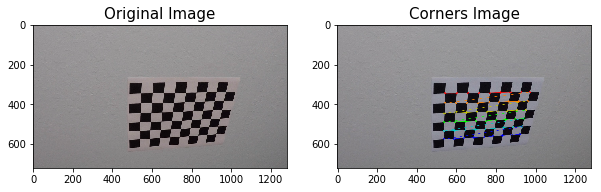

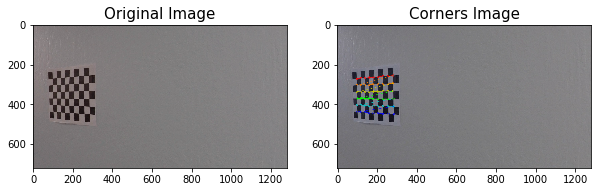

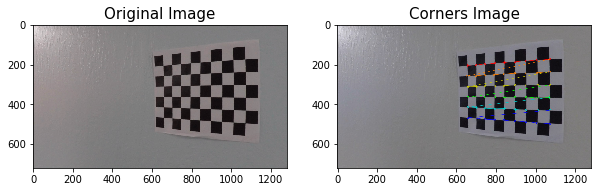

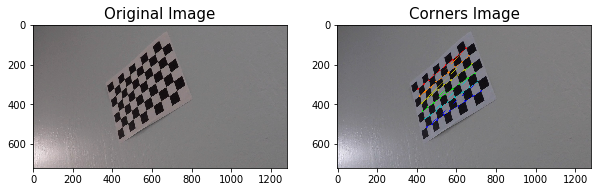

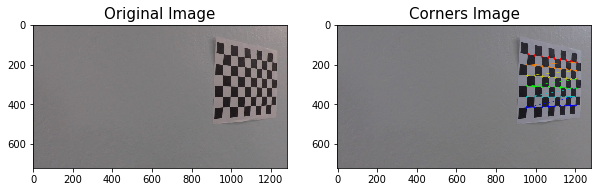

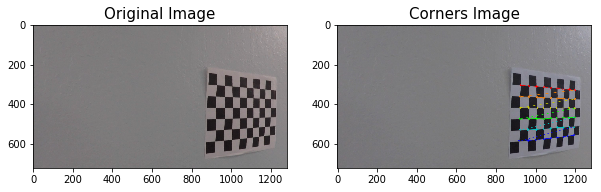

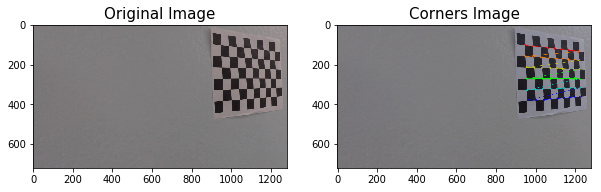

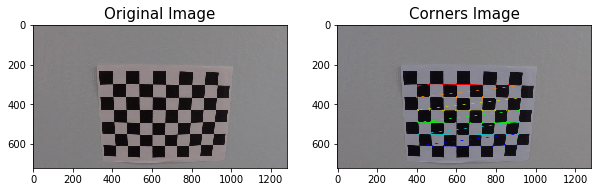

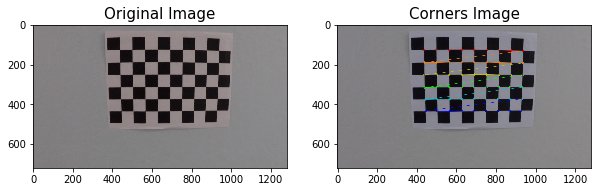

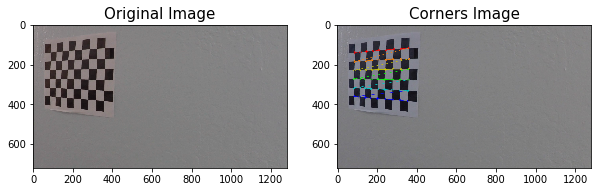

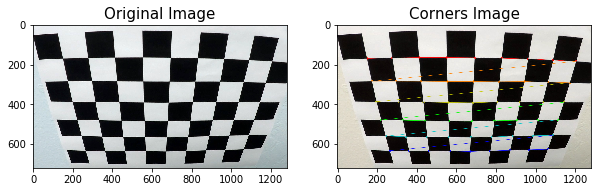

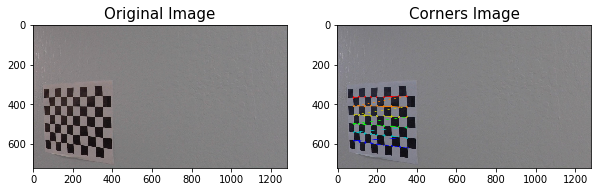

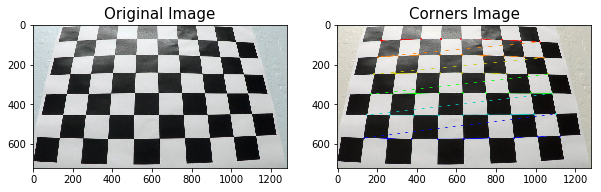

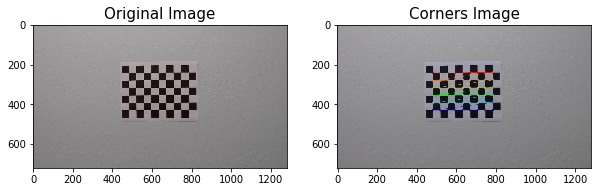

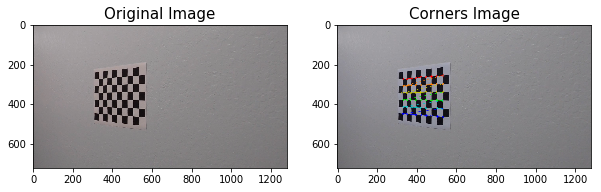

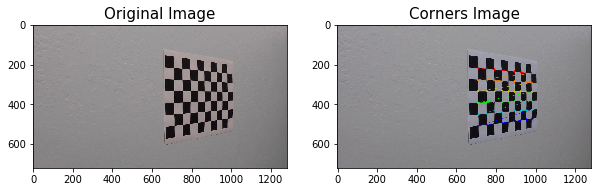

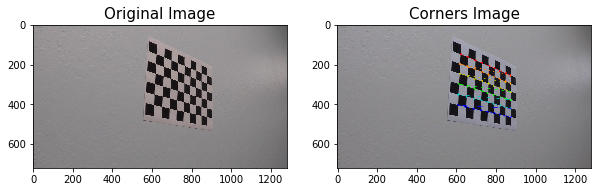

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

nx = 9
ny = 6

# arrays to store object points and image points from all the images.
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# prepare object points
objp = np.zeros((6*9, 3), np.float32) # same 3D from (0,0,0) to (7,5,0)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coord; mgrid returns coord values 

images = glob.glob('./camera_cal/calibration*.jpg')

for _, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Corners Image', fontsize=15)        
    plt.show()

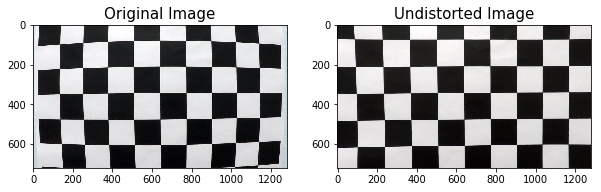

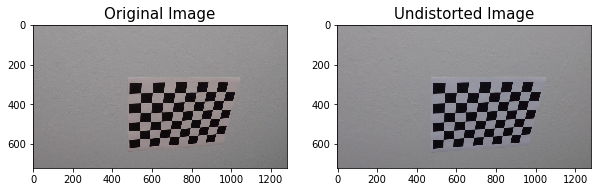

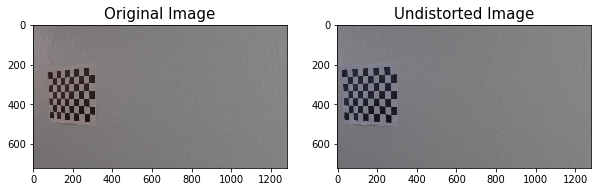

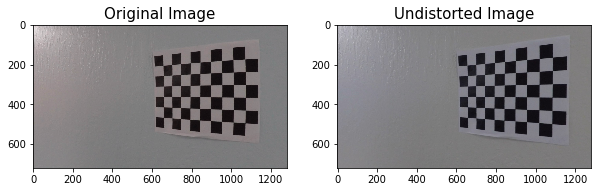

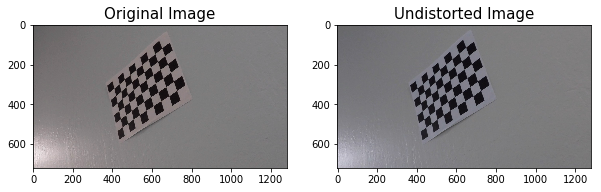

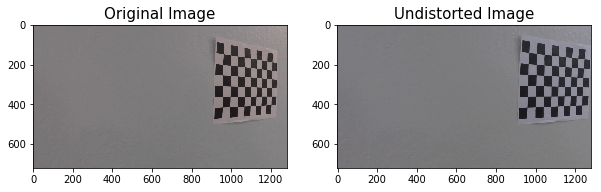

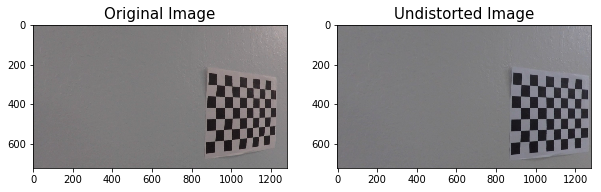

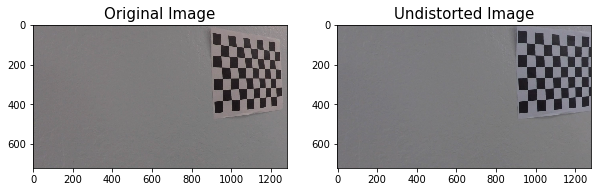

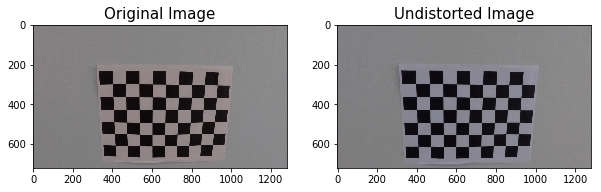

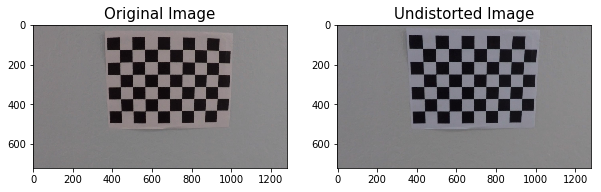

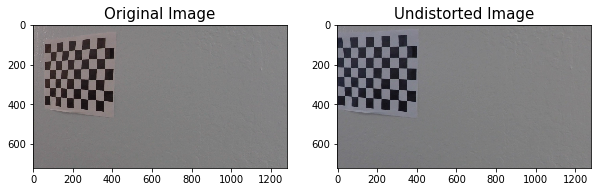

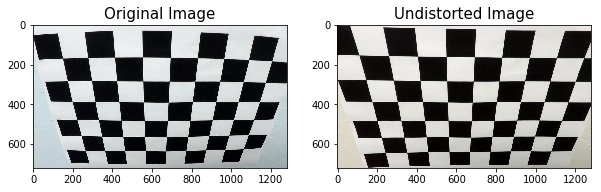

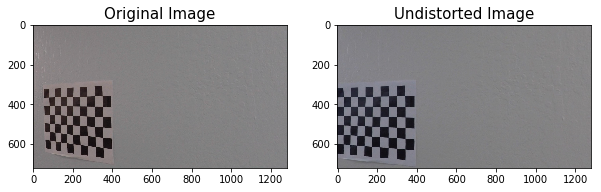

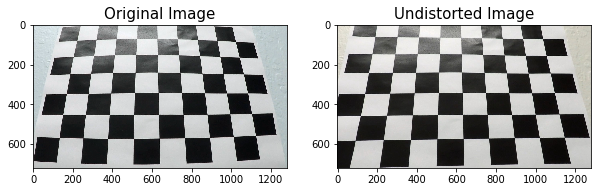

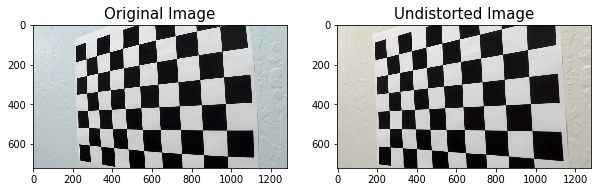

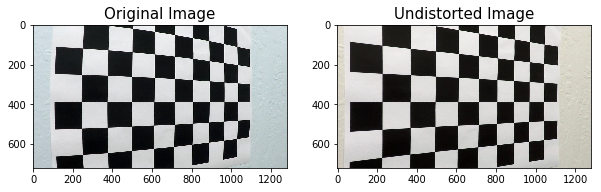

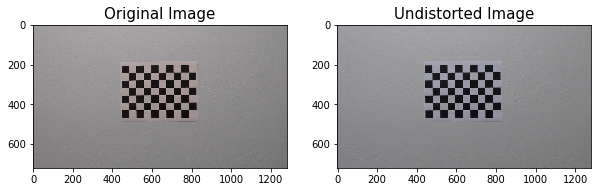

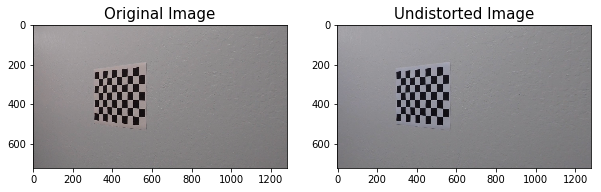

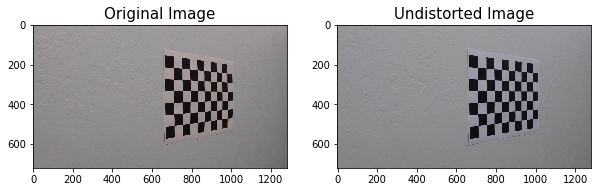

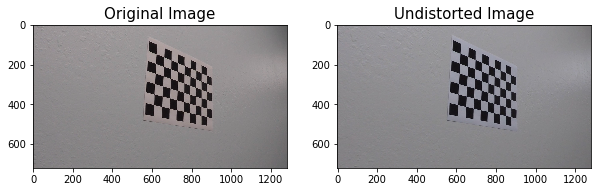

In [4]:
def undistorted_correction(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

for _, fname in enumerate(images):
    img = cv2.imread(fname)
    undistorted = undistorted_correction(img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize = 15)
    ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize = 15)
plt.show()

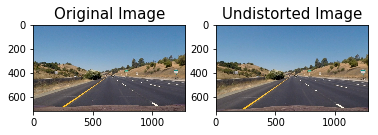

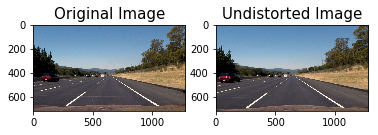

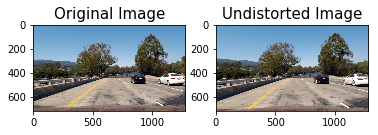

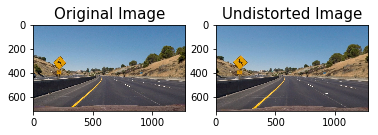

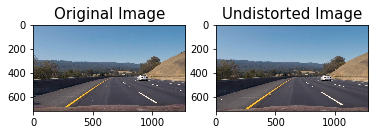

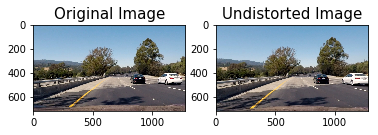

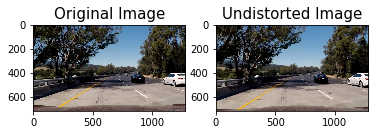

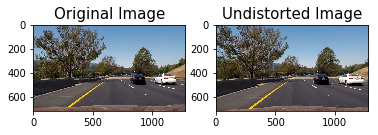

In [5]:
test_images = glob.glob('./test_images/*.jpg')
for _, fname in enumerate(test_images):
    img = cv2.imread(fname)
    undistorted = undistorted_correction(img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=15)
plt.show()

(-0.5, 1279.5, 719.5, -0.5)

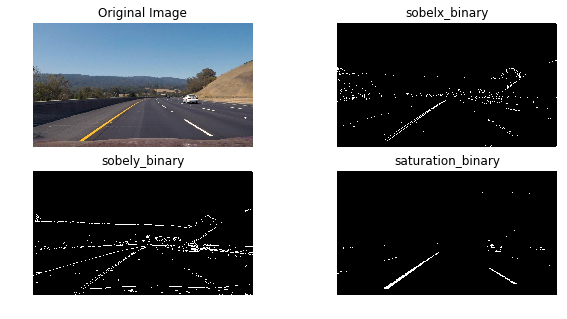

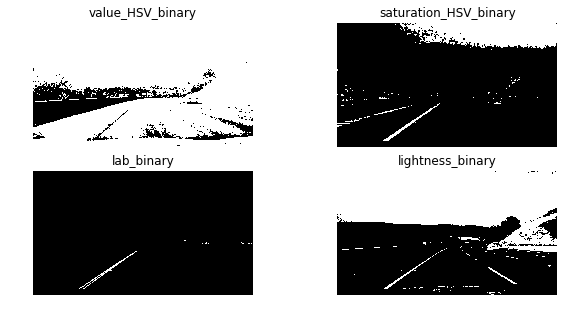

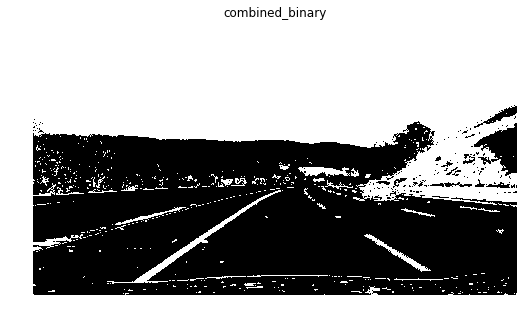

In [6]:
img = mpimg.imread('./test_images/test3.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    if orient=='x': abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient=='y': abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # rescale 8-bit
    sobel_binary = np.zeros_like(scaled_sobel) # create a copy and apply threshold
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_binary

def HLS_thresh(img, thresh=(0, 255)): # (170,255) (150,255) (180, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    ch = hls[:,:,2] # saturation
    hls_binary = np.zeros_like(ch)
    hls_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    return hls_binary

def HSV_thresh(img, channel='v', thresh=(0,255)):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    if channel=='v': ch = hsv[:,:,2] # value
    if channel=='s': ch = hsv[:,:,1] # saturation
    hsv_binary = np.zeros_like(ch)
    hsv_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    return hsv_binary

def LUV_thresh(img, thresh=(0,255)):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    ch = luv[:,:,0] 
    luv_binary = np.zeros_like(ch)
    luv_binary[(ch >= thresh[0]) & (ch <= thresh[1])]
    return luv_binary

def LAB_thresh(img, thresh=(0,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab) # convert RGB to floating-point format and scaled to fit the 0 to 1 range.
    lab2 = lab[:,:,2]
    lab_binary = np.zeros_like(lab2)
    lab_binary[((lab2 >= thresh[0]) & (lab2 <= thresh[1]))] = 1
    return lab_binary

def lightness_mask(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2]
    lightness = hls[:,:,1]
    lightness_binary = np.zeros_like(saturation)
    lightness_binary[(saturation >=thresh[0]) & (lightness>=thresh[1])] = 1
    return lightness_binary

def combined_gradient_thresholds(img): # img: undistorted image
    sobelx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(30,90))
    sobely_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=5, thresh=(30,90))
    saturation_binary = HLS_thresh(img, thresh=(120,255))
    value_HSV_binary = HSV_thresh(img, channel='v', thresh=(75,255))
    saturation_HSV_binary = HSV_thresh(img, channel='s', thresh=(120,255))
    #luv_binary = LUV_thresh(img, thresh=(225,255))
    lightness_binary = lightness_mask(img, thresh=(5,130))
    #lab_binary = LAB_thresh(img, thresh=(155,200))
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(saturation_HSV_binary==1) | (sobelx_binary==1) | (sobely_binary==1) & (value_HSV_binary==1) | (lightness_binary==1)]=1 ## 
    return combined_binary


sobelx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(30,90))
sobely_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=5, thresh=(30,90))

saturation_binary = HLS_thresh(img, thresh=(120,255))
value_HSV_binary = HSV_thresh(img, channel='v', thresh=(75,255))
saturation_HSV_binary = HSV_thresh(img, channel='s', thresh=(120,255))

luv_binary = LUV_thresh(img, thresh=(30,12))
lightness_binary = lightness_mask(img, thresh=(5,130))
lab_binary = LAB_thresh(img, thresh=(155,200))
combined_binary = combined_gradient_thresholds(img)



f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax1.axis('off')

ax2.imshow(sobelx_binary, cmap='gray')
ax2.set_title('sobelx_binary', fontsize=12)
ax2.axis('off')

ax3.imshow(sobely_binary, cmap='gray')
ax3.set_title('sobely_binary', fontsize=12)
ax3.axis('off')

ax4.imshow(saturation_binary, cmap='gray')
ax4.set_title('saturation_binary', fontsize=12)
ax4.axis('off')

f, ((ax5,ax6),(ax7,ax8)) = plt.subplots(2, 2, figsize=(10,5))
ax5.imshow(value_HSV_binary, cmap='gray')
ax5.set_title('value_HSV_binary', fontsize=12)
ax5.axis('off')

ax6.imshow(saturation_HSV_binary, cmap='gray')
ax6.set_title('saturation_HSV_binary', fontsize=12)
ax6.axis('off')

ax7.imshow(lab_binary, cmap='gray')
ax7.set_title('lab_binary', fontsize=12)
ax7.axis('off')

ax8.imshow(lightness_binary, cmap='gray')
ax8.set_title('lightness_binary', fontsize=12)
ax8.axis('off')

f, (ax9) = plt.subplots(1, 1, figsize=(12,5))
ax9.imshow(combined_binary, cmap='gray')
ax9.set_title('combined_binary', fontsize=12)
ax9.axis('off')

In [7]:
def perspective_transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, warped
def bird_eye_perspective(img, src, dst):
    undist = undistorted_correction(img, objpoints, imgpoints) # undistorted image
    M, Minv, warped = perspective_transform(undist, src, dst)
    return M, Minv, warped, undist

In [8]:
img = mpimg.imread('test_images/test3.jpg')

src = np.float32([[585,460], [203,720],
            [1127,720], [695,460]])
dst = np.float32([[320,0], [320,720],
            [960,720], [960,0]])

(-0.5, 1279.5, 719.5, -0.5)

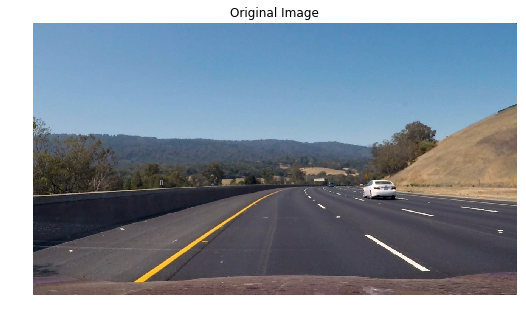

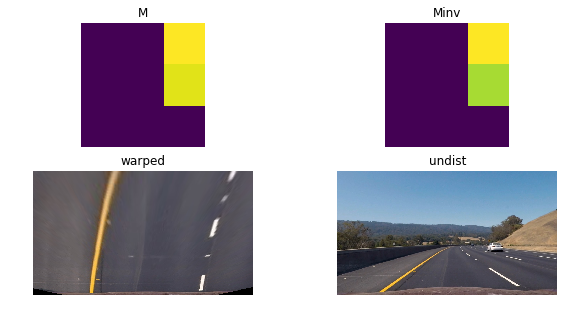

In [9]:
M, Minv, warped = perspective_transform(img, src, dst)
_, _, _, undist = bird_eye_perspective(img, src, dst)

f, (ax0) = plt.subplots(1, 1, figsize=(12,5))
ax0.imshow(img)
ax0.set_title('Original Image', fontsize=12)
ax0.axis('off')

f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax1.imshow(M)
ax1.set_title('M', fontsize=12)
ax1.axis('off')

ax2.imshow(Minv)
ax2.set_title('Minv', fontsize=12)
ax2.axis('off')

ax3.imshow(warped, cmap='gray')
ax3.set_title('warped', fontsize=12)
ax3.axis('off')

ax4.imshow(undist, cmap='gray')
ax4.set_title('undist', fontsize=12)
ax4.axis('off')

(720, 1280)


(-0.5, 1279.5, 719.5, -0.5)

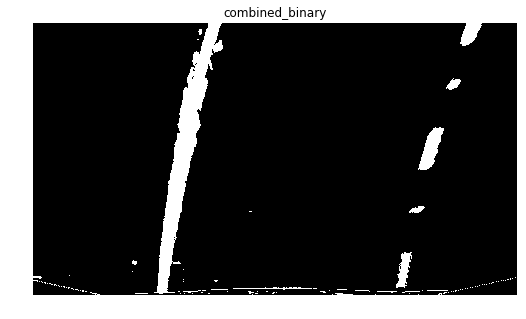

In [10]:
def apply_binary(img, src, dst):
    M, Minv, warped, undist = bird_eye_perspective(img, src, dst) # warped image is undistorte and warped.
    combined_binary = combined_gradient_thresholds(warped) # sobelx+saturation+value
    return combined_binary, warped, M, Minv, undist

combined_binary, warped, M, Minv, undist = apply_binary(img, src, dst)
print(combined_binary.shape)

f, (ax0) = plt.subplots(1, 1, figsize=(10,5))
ax0.imshow(combined_binary, cmap='gray')
ax0.set_title('combined_binary', fontsize=12)
ax0.axis('off')


In [11]:
def find_lane_lines(combined_binary):
    histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
    for window in range(nwindows): 
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # 

            # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
        #Pixel position for left and right
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        #Fit 2nd polynomial
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx,2)
    
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty,rightx] = [0,0,255]

    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    return out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy


(720, 0)

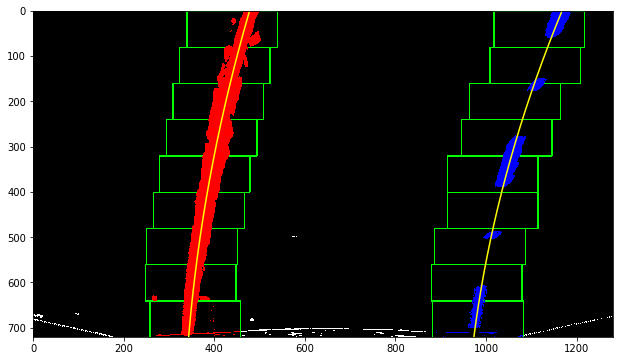

In [12]:
global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly

out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy = find_lane_lines(combined_binary)

ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(15,6))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

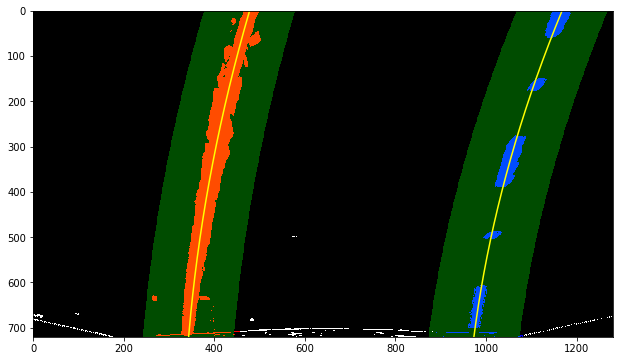

In [13]:
margin=100
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(15,6))
plt.imshow(result)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

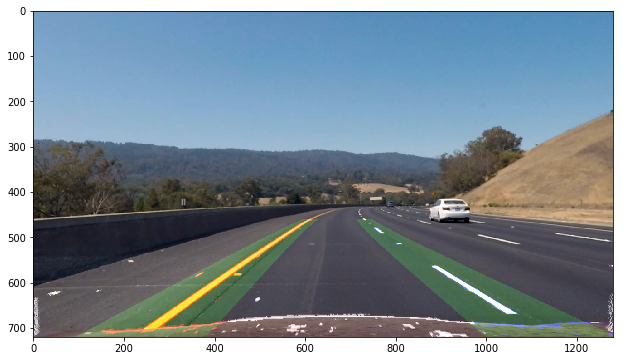

In [14]:
_, _, unwarped = perspective_transform(result, dst, src)
undist_cp = np.copy(undist)
final = cv2.addWeighted(undist_cp, 1, unwarped,0.5,0)
plt.figure(figsize=(15,6))
plt.imshow(final)

In [16]:
def get_curvature(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return (left_curverad, right_curverad)

def get_center(img, ploty, left_fit, right_fit):
    ymax = np.max(ploty)
    xm_per_pix = 3.7/700 # meters per px in x-dim (conversions in x,y from pixels space to meters)
    left = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
    right = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
    center = (left + right) / 2
    return (img.shape[1]/2 - center)*xm_per_pix

def draw_lines(img, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2) 
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    left_points = np.vstack(([left_fitx.T], [lefty.T])).T
    right_points = np.vstack(([right_fitx.T], [righty.T])).T
    all_points = np.concatenate((left_points, right_points[::-1]))

    cv2.fillConvexPoly(img, np.int32([all_points]), (0, 255, 0))
    cv2.polylines(img, np.int32([left_points]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([right_points]), False, (255, 0, 0), 20)        
    return img

In [17]:
def pipeline_process(img):
    src = np.float32([[585,460], [203,720],
            [1127,720], [695,460]])
    dst = np.float32([[320,0], [320,720],
            [960,720], [960,0]])

    combined_binary, warped, M, Minv, undist = apply_binary(img, src, dst)
    
    global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
    
    out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy = find_lane_lines(combined_binary)
    
    drawwarped = draw_lines(np.zeros_like(warped), leftx, lefty, rightx, righty)
    _, _, unwarped = perspective_transform(drawwarped, dst, src)
    output = cv2.addWeighted(undist, 1, unwarped, 0.3, 0.0)
    
    left_curverad, right_curverad = get_curvature(lefty, leftx, lefty, rightx, righty, left_fit, right_fit)
    curvature = min([left_curverad, right_curverad])
    text = "Curvature of Radius: {:.2f} m".format(curvature)
    cv2.putText(output, text, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    text1 = "Left curve: {:.2f} m".format(left_curverad)
    cv2.putText(output, text1, (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    text1 = "Right curve: {:.2f} m ".format(right_curverad)
    cv2.putText(output, text1, (50,260), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pos = get_center(img, ploty, left_fit, right_fit)
    if pos < 0:
        text = "Vehicle is {:.2f} m on left".format(-pos)
    else:
        text = "Vehicle is {:.2f} m on right".format(pos)
    cv2.putText(output, text, (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return output

In [18]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters
ym_per_pix = 30./720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

In [19]:
def my_pipeline(img):
    src = np.float32([[585,460], [203,720],
            [1127,720], [695,460]])
    dst = np.float32([[320,0], [320,720],
            [960,720], [960,0]])

    combined_binary, warped, M, Minv, undist = apply_binary(img, src, dst)
    
    global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
    
    out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy = find_lane_lines(combined_binary)
    
    drawwarped = draw_lines(np.zeros_like(warped), leftx, lefty, rightx, righty)
    _, _, unwarped = perspective_transform(drawwarped, dst, src)
    output = cv2.addWeighted(undist, 1, unwarped, 0.3, 0.0)
    
    left_curverad, right_curverad = get_curvature(lefty, leftx, lefty, rightx, righty, left_fit, right_fit)
    curvature = min([left_curverad, right_curverad])
    text = "Curvature of Radius: {:.2f} m".format(curvature)
    cv2.putText(output, text, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    text1 = "Left curve: {:.2f} m".format(left_curverad)
    cv2.putText(output, text1, (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (25,255,255), 2)
    text1 = "Right curve: {:.2f} m ".format(right_curverad)
    cv2.putText(output, text1, (50,260), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pos = get_center(img, ploty, left_fit, right_fit)
    if pos < 0:
        text = "Vehicle is {:.2f} m on left".format(-pos)
    else:
        text = "Vehicle is {:.2f} m on right".format(pos)
    cv2.putText(output, text, (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    return output

In [20]:
output=  my_pipeline(img)

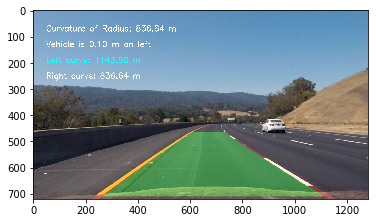

In [21]:
plt.imshow(output)

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'AA.mp4'
clip2 = VideoFileClip('project_video.mp4')

global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly

project_clip = clip2.fl_image(my_pipeline)
%time project_clip.write_videofile(project_output, fps = 25, audio= False)

[MoviePy] >>>> Building video AA.mp4
[MoviePy] Writing video AA.mp4


100%|█████████▉| 1260/1261 [5:46:44<00:01,  1.44s/it]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: AA.mp4 

CPU times: user 1h 4min 21s, sys: 10min 30s, total: 1h 14min 51s
Wall time: 5h 46min 46s
